# StepFunctions Data Science SDK for BYO Container

Here we demonstrate how to use the StepFunction Data Science SDK to do an end-to-end data science workflow where you bring your own code and deploy a model on SageMaker.

The Steps are as follows:


1/ Create a Lambda function which launches a CodeBuild job that launches the creation of your Docker container. (Steps for this are included separately)

2/ Launch the Lambda function as a Step Functions workflow. 

3/ Once the Docker container is built, launch a SageMaker training job using SF DS SDK.

4/ Use the DS SDK to deploy the trained model.

## TODO: IAM Roles and Permissions

Before running the code, ensure that your Amazon SageMaker notebook IAM role can call the AWS StepFunctions SDK, and vice-versa.

To do this, follow the steps in the Setup Section of this notebook upto the section "Configure Execution Roles": https://github.com/awslabs/amazon-sagemaker-examples/blob/master/step-functions-data-science-sdk/machine_learning_workflow_abalone/machine_learning_workflow_abalone.ipynb


If you have already completed this, then ignore this section and move on to the next.

## Setup

### Add a policy to your SageMaker role in IAM

**If you are running this notebook on an Amazon SageMaker notebook instance**, the IAM role assumed by your notebook instance needs permission to create and run workflows in AWS Step Functions. To provide this permission to the role, do the following.

1. Open the Amazon [SageMaker console](https://console.aws.amazon.com/sagemaker/). 
2. Select **Notebook instances** and choose the name of your notebook instance
3. Under **Permissions and encryption** select the role ARN to view the role on the IAM console
4. Choose **Attach policies** and search for `AWSStepFunctionsFullAccess`.
5. Select the check box next to `AWSStepFunctionsFullAccess` and choose **Attach policy**

If you are running this notebook in a local environment, the SDK will use your configured AWS CLI configuration. For more information, see [Configuring the AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html).

Next, create an execution role in IAM for Step Functions. 

### Create an execution role for Step Functions

You need an execution role so that you can create and execute workflows in Step Functions.

1. Go to the [IAM console](https://console.aws.amazon.com/iam/)
2. Select **Roles** and then **Create role**.
3. Under **Choose the service that will use this role** select **Step Functions**
4. Choose **Next** until you can enter a **Role name**
5. Enter a name such as `StepFunctionsWorkflowExecutionRole` and then select **Create role**


Attach a policy to the role you created. The following steps attach a policy that provides full access to Step Functions, however as a good practice you should only provide access to the resources you need.  

1. Under the **Permissions** tab, click **Add inline policy**
2. Enter the following in the **JSON** tab

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "sagemaker:CreateTransformJob",
                "sagemaker:DescribeTransformJob",
                "sagemaker:StopTransformJob",
                "sagemaker:CreateTrainingJob",
                "sagemaker:DescribeTrainingJob",
                "sagemaker:StopTrainingJob",
                "sagemaker:CreateHyperParameterTuningJob",
                "sagemaker:DescribeHyperParameterTuningJob",
                "sagemaker:StopHyperParameterTuningJob",
                "sagemaker:CreateModel",
                "sagemaker:CreateEndpointConfig",
                "sagemaker:CreateEndpoint",
                "sagemaker:DeleteEndpointConfig",
                "sagemaker:DeleteEndpoint",
                "sagemaker:UpdateEndpoint",
                "sagemaker:ListTags",
                "lambda:InvokeFunction",
                "sqs:SendMessage",
                "sns:Publish",
                "ecs:RunTask",
                "ecs:StopTask",
                "ecs:DescribeTasks",
                "dynamodb:GetItem",
                "dynamodb:PutItem",
                "dynamodb:UpdateItem",
                "dynamodb:DeleteItem",
                "batch:SubmitJob",
                "batch:DescribeJobs",
                "batch:TerminateJob",
                "glue:StartJobRun",
                "glue:GetJobRun",
                "glue:GetJobRuns",
                "glue:BatchStopJobRun"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:PassRole"
            ],
            "Resource": "*",
            "Condition": {
                "StringEquals": {
                    "iam:PassedToService": "sagemaker.amazonaws.com"
                }
            }
        },
        {
            "Effect": "Allow",
            "Action": [
                "events:PutTargets",
                "events:PutRule",
                "events:DescribeRule"
            ],
            "Resource": [
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTrainingJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTransformJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTuningJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForECSTaskRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForBatchJobsRule"
            ]
        }
    ]
}
```

3. Choose **Review policy** and give the policy a name such as `StepFunctionsWorkflowExecutionPolicy`
4. Choose **Create policy**. You will be redirected to the details page for the role.
5. Copy the **Role ARN** at the top of the **Summary**

## Import necessary libraries

In [54]:
# Import required libraries and upload the training data to S3
import boto3
import os
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import time
import uuid
import json

sm_client = boto3.client('sagemaker')
role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket() # or feel free to replace with a bucket of your choosing
WORK_DIRECTORY = 'PennFudanPed'
key = 'BYO-Mask-RCNN'
prefix = '{}/{}'.format(key, WORK_DIRECTORY)
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name

In [2]:
# TODO: replace the IAM role below with the StepFunctionsWorkflowExecutionRole ARN from the role set up. Generally,
# it looks like this:
workflow_execution_role = "arn:aws:iam::{}:role/StepFunctionsWorkflowExecutionRole".format(account)

In [ ]:
# install StepFunctions SDK
import sys
!{sys.executable} -m pip install --upgrade stepfunctions

In [4]:
import stepfunctions
import logging
from stepfunctions.steps import (LambdaStep, Retry, Catch, Fail, Chain, TrainingStep, ModelStep, EndpointConfigStep, EndpointStep)
from stepfunctions.workflow import Workflow
from stepfunctions.template.pipeline import TrainingPipeline
from stepfunctions.inputs import ExecutionInput

stepfunctions.set_stream_logger(level=logging.INFO)

## Download training dataset

In [5]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

--2020-06-08 11:56:47--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.1’

PennFudanPed.zip.1  100%[===================>]  51.23M  1009KB/s    in 48s     

2020-06-08 11:57:34 (1.07 MB/s) - ‘PennFudanPed.zip.1’ saved [53723336/53723336]



In [ ]:
!unzip PennFudanPed.zip

## Upload the training dataset to Amazon S3

In [7]:
data_location = sess.upload_data(WORK_DIRECTORY, bucket=bucket, key_prefix=prefix)
print(data_location)

s3://sagemaker-us-east-1-355151823911/BYO-Mask-RCNN/PennFudanPed


# Define Estimator and StepFunctions Workflow

In [192]:
image = '{}.dkr.ecr.{}.amazonaws.com/sm-container-maskrcnn:torch'.format(account, region) 

maskrcnn = sagemaker.estimator.Estimator(image,
                       role, 1, 'ml.p2.xlarge', #feel free to modify with your own. A cost estimate is provided in Readme.
                       output_path="s3://{}/{}/output".format(sess.default_bucket(), key),
                       sagemaker_session=sess)

maskrcnn.set_hyperparameters(num_epochs  = 1,
                             num_classes = 2)

### Create StepFunction Pipeline

**IMPORTANT** Replace the Lambda function name below with the Lambda function created in the Outputs of CloudFormation

In [193]:
lambda_state = LambdaStep(
    state_id="Calls CodeBuild to Build Container",
    parameters={  
        "FunctionName": "lambda-build-docker-maskrcnn", 
        "Payload": {  
           "input": " "
        }
    }
)

lambda_state.add_retry(Retry(
    error_equals=["States.TaskFailed"],
    interval_seconds=15,
    max_attempts=2,
    backoff_rate=4.0
))

lambda_state.add_catch(Catch(
    error_equals=["States.TaskFailed"],
    next_step=Fail("LambdaTaskFailed")
))

In [194]:
execution_input = ExecutionInput(schema={
    'JobName': str, 
    'ModelName': str,
    'EndpointName': str
})

In [196]:
train_step = TrainingStep(
    'Train Step', 
    estimator=maskrcnn,
    data=os.path.dirname(data_location),
    job_name=execution_input['JobName']
)

In [197]:
model_step = ModelStep(
    'Save model',
    model=train_step.get_expected_model(),
    model_name=execution_input['ModelName'] 
)

In [198]:
endpoint_config_step = EndpointConfigStep(
    "Create Endpoint Config",
    endpoint_config_name=execution_input['ModelName'],
    model_name=execution_input['ModelName'],
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

In [199]:
endpoint_step = EndpointStep(
    "Create Endpoint",
    endpoint_name=execution_input['EndpointName'],
    endpoint_config_name=execution_input['ModelName']
)

In [200]:
workflow_definition = Chain([
    lambda_state,
    train_step,
    model_step,
    endpoint_config_step,
    endpoint_step
])

# Next, we define the workflow
workflow = Workflow(
    name="MyWorkflow-BYOC-MaskRCNN-{}".format(uuid.uuid1().hex),
    definition=workflow_definition,
    role=workflow_execution_role
)

In [201]:
print(workflow.definition.to_json(pretty=True))

{
    "StartAt": "Calls CodeBuild to Build Container",
    "States": {
        "Calls CodeBuild to Build Container": {
            "Parameters": {
                "FunctionName": "lambda-build-docker-maskrcnn",
                "Payload": {
                    "input": " "
                }
            },
            "Resource": "arn:aws:states:::lambda:invoke",
            "Type": "Task",
            "Next": "Train Step",
            "Retry": [
                {
                    "ErrorEquals": [
                        "States.TaskFailed"
                    ],
                    "IntervalSeconds": 15,
                    "MaxAttempts": 2,
                    "BackoffRate": 4.0
                }
            ],
            "Catch": [
                {
                    "ErrorEquals": [
                        "States.TaskFailed"
                    ],
                    "Next": "LambdaTaskFailed"
                }
            ]
        },
        "Train Step": {
            "Reso

In [202]:
workflow.render_graph()

In [206]:
workflow.create()

[WARNING] The workflow already exists on AWS Step Functions. No action will be performed.


'arn:aws:states:us-east-1:355151823911:stateMachine:MyWorkflow-BYOC-MaskRCNN-2f01a088ab0f11eaabac3dd468b6f73a'

In [215]:
execution = workflow.execute(
    inputs={
        'JobName': 'BYOC-Mask-RCNN-{}'.format(uuid.uuid1().hex), # Each Sagemaker Job requires a unique name
        'ModelName': 'BYOC-Mask-RCNN-{}'.format(uuid.uuid1().hex), # Each Model requires a unique name,
        'EndpointName': 'BYOC-Mask-RCNN-{}'.format(uuid.uuid1().hex) # Each Endpoint requires a unique name,
    }
)

[INFO] Workflow execution started successfully on AWS Step Functions.


## Watch the progress of your workflow here

In [216]:
from IPython.display import display, display_html
while True:
    display_html(execution.render_progress())
    time.sleep(60)

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

KeyboardInterrupt: 

## Inferences

Once your model is deployed, you can run inferences using this endpoint by using the SageMaker RealTimePredictor API. Please refer to the existing SageMaker documentation for how to do this.

Also to ensure you don't rack up costs, make sure you delete the endpoint once you are done. 

**Important**: Replace the endpoint name below with your endpoint. To find the name, navigate to the SageMaker Console --> Endpoints and look for the name starting with 'BYOC_Mask-RCNN-*******'. **Make sure that your endpoint is up and running before you proceed!**

In [217]:
# Let's take a look at the SageMaker Console to get the endpoint name
endpoint_name = 'BYOC-Mask-RCNN-d8bb2040ab1411eaabac3dd468b6f73a' # TO DO: REPLACE this with your endpoint
from sagemaker.predictor import RealTimePredictor

predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

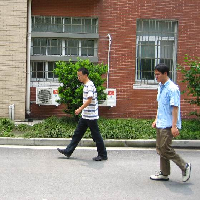

In [218]:
# Let's take an input image and run inference on it.
from PIL import Image
import numpy as np
SMALL_IMAGE = (200,200)

f = f'{WORK_DIRECTORY}/PNGImages/FudanPed00001.png'
Image.open(f).resize(SMALL_IMAGE)

In [219]:
import json
img = np.array(Image.open(f).resize(SMALL_IMAGE))
print(f)
imginput = json.dumps(img.tolist())

PennFudanPed/PNGImages/FudanPed00001.png


In [220]:
result = predictor.predict(imginput)
prediction = json.loads(result)

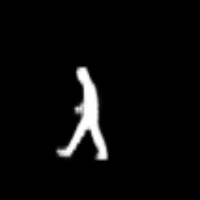

In [221]:
Image.fromarray(np.uint8(np.asarray(prediction[0][0])*255)).resize(SMALL_IMAGE)

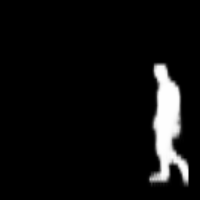

In [222]:
Image.fromarray(np.uint8(np.asarray(prediction[1][0])*255)).resize(SMALL_IMAGE)

In [223]:
sess.delete_endpoint(predictor.endpoint)

## Model Monitoring
Here we will re-deploy the model with data capture enabled, and will re-run a set of inferences to show that requests and responses are saved for further analysis and ongoing model refinement.

In [224]:
model_name = execution.get_input()['ModelName']
s3_capture_path = f's3://{bucket}/{key}/capture'
s3_capture_path

's3://sagemaker-us-east-1-355151823911/BYO-Mask-RCNN/capture'

In [225]:
from time import gmtime, strftime

print(f'Capture path: {s3_capture_path}')

## This is the option in EndpointConfiguration which enable capturing data
data_capture_configuration = {
    'EnableCapture': True, # flag turns data capture on and off
    'InitialSamplingPercentage': 100, # sampling rate to capture data. max is 100%
    'DestinationS3Uri': s3_capture_path, # s3 location where captured data is saved
    'CaptureOptions': [
        {
            'CaptureMode': 'Output'
        },
        {
            'CaptureMode': 'Input'
        }
    ],
}

ts = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
endpoint_config_name = f'{key}-model-monitor-{ts}' 
print(f'EndpointConfig: {endpoint_config_name}')
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.c5.xlarge',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTrafficVariant'
    }],
    DataCaptureConfig = data_capture_configuration) # This is where the new capture options are applied

epc_arn = create_endpoint_config_response['EndpointConfigArn']
print(f'Endpoint Config Arn: {epc_arn}')

Capture path: s3://sagemaker-us-east-1-355151823911/BYO-Mask-RCNN/capture
EndpointConfig: BYO-Mask-RCNN-model-monitor-2020-06-10-12-46-01
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:355151823911:endpoint-config/byo-mask-rcnn-model-monitor-2020-06-10-12-46-01


In [226]:
%%time
import time

endpoint_name = f'{key}-{ts}'
print(endpoint_name)
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print(f'Status: {status}')

while status=='Creating':
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print(f'Status: {status}')

ep_arn = resp['EndpointArn']
print(f'Arn: {ep_arn}')
print(f'Status: {status}')


BYO-Mask-RCNN-2020-06-10-12-46-01
arn:aws:sagemaker:us-east-1:355151823911:endpoint/byo-mask-rcnn-2020-06-10-12-46-01
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:355151823911:endpoint/byo-mask-rcnn-2020-06-10-12-46-01
Status: InService
CPU times: user 105 ms, sys: 16 ms, total: 121 ms
Wall time: 8min 1s


In [227]:
predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

Finding walkers in image: PennFudanPed/PNGImages/FudanPed00001.png


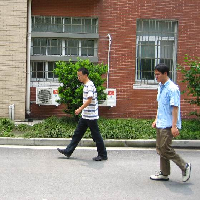

Finding walkers in image: PennFudanPed/PNGImages/FudanPed00002.png


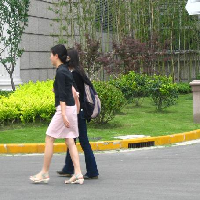

Finding walkers in image: PennFudanPed/PNGImages/FudanPed00003.png


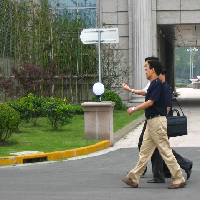

In [254]:
for i in range(1, 4):
    f = f'{WORK_DIRECTORY}/PNGImages/FudanPed{i:05d}.png'
    print(f'Finding walkers in image: {f}')
    pil_img = Image.open(f).resize(SMALL_IMAGE)
    display(pil_img)
    img = np.array(pil_img)
    imginput = json.dumps(img.tolist())
    result = predictor.predict(imginput)

In [256]:
s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=bucket, Prefix=capture_prefix)
capture_files = sorted([capture_file.get('Key') for capture_file in result.get('Contents')], reverse=True)
print(f'Found {len(capture_files)} Capture Files:\n')
print('\n '.join(capture_files))

Found 46 Capture Files:

BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/13/22-50-554-a5349bd5-88fd-410a-9c0a-49a3bac314cb.jsonl
 BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/13/12-37-843-5ce890bd-d888-4a95-87c6-296271b251c1.jsonl
 BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/13/08-46-962-c954e699-8315-4ed7-bd15-fc4284a1e3da.jsonl
 BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/13/03-00-375-9e4a7951-e750-42e1-8bd7-71f816d6e40e.jsonl
 BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/12/54-24-336-f2f51f4e-ba1f-4299-a82b-72780cdc1c0e.jsonl
 BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-10-58-29/AllTrafficVariant/2020/06/10/11/26-33-938-b357db16-39bd-49ed-9697-27963dea0a15.jsonl
 BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-10-58-29/AllTrafficVariant/2020/06/10/11/24-26-489-21d8b96b-8b3f-4fcd-8e9b-9

BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/13/22-50-554-a5349bd5-88fd-410a-9c0a-49a3bac314cb.jsonl
JSONL file has 3 JSON objects.
 1/ 3) inference time: 2020-06-10T13:22:50Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 634 kb
       output size     : 912 kb
       Input image:


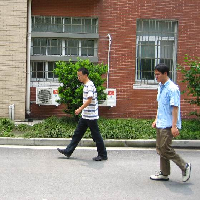

       Output images (2):


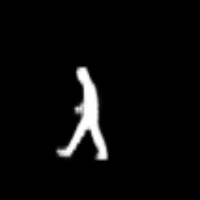

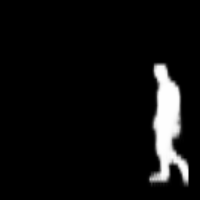

 2/ 3) inference time: 2020-06-10T13:22:53Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 634 kb
       output size     : 646 kb
       Input image:


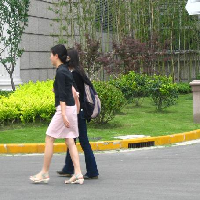

       Output images (1):


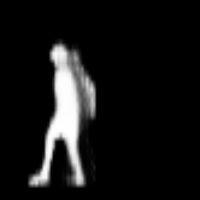

 3/ 3) inference time: 2020-06-10T13:22:56Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 629 kb
       output size     : 634 kb
       Input image:


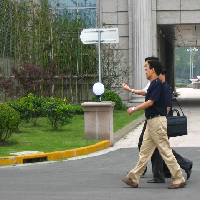

       Output images (1):


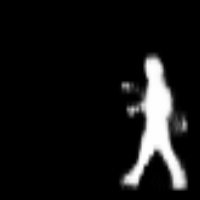

BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/13/12-37-843-5ce890bd-d888-4a95-87c6-296271b251c1.jsonl
JSONL file has 2 JSON objects.
 1/ 2) inference time: 2020-06-10T13:12:37Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 634 kb
       output size     : 646 kb
       Input image:


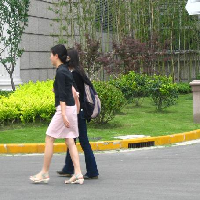

       Output images (1):


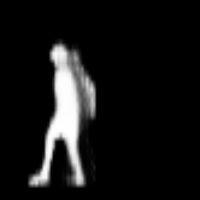

 2/ 2) inference time: 2020-06-10T13:12:40Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 629 kb
       output size     : 634 kb
       Input image:


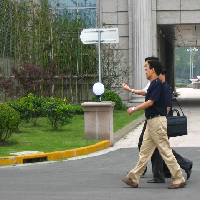

       Output images (1):


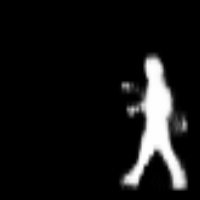

BYO-Mask-RCNN/capture/BYO-Mask-RCNN-2020-06-10-12-46-01/AllTrafficVariant/2020/06/10/13/08-46-962-c954e699-8315-4ed7-bd15-fc4284a1e3da.jsonl
JSONL file has 3 JSON objects.
 1/ 3) inference time: 2020-06-10T13:08:46Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 634 kb
       output size     : 912 kb
       Input image:


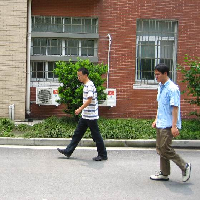

       Output images (2):


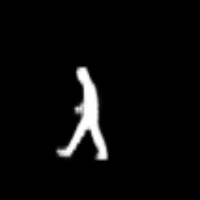

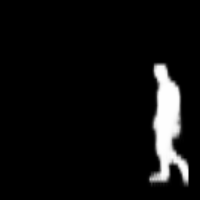

 2/ 3) inference time: 2020-06-10T13:08:50Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 634 kb
       output size     : 646 kb
       Input image:


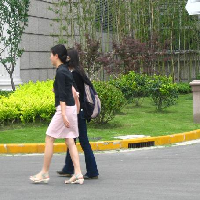

       Output images (1):


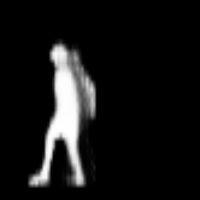

 3/ 3) inference time: 2020-06-10T13:08:52Z
       in mode : INPUT, out mode: OUTPUT
       out type: text/csv; charset=utf-8, out encoding: BASE64
       input image size: 629 kb
       output size     : 634 kb
       Input image:


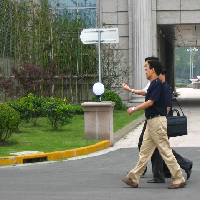

       Output images (1):


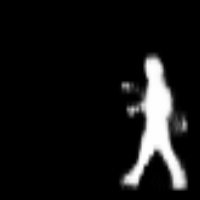

In [259]:
import base64

def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode('utf-8')

def content_summary(jsonl_fn):
    capture_file = get_obj_body(jsonl_fn)
    indiv_jsons = capture_file.split('\n')
    num_objs = len(indiv_jsons)-1
    print(f'JSONL file has {num_objs} JSON objects.')
    for i in range(num_objs):
        capture_json = json.loads(indiv_jsons[i])

        in_mode  = capture_json['captureData']['endpointInput']['mode']
        out_mode = capture_json['captureData']['endpointOutput']['mode']

        input_data = capture_json['captureData']['endpointInput']['data']
        output_data = capture_json['captureData']['endpointOutput']['data']

        out_type = capture_json['captureData']['endpointOutput']['observedContentType']
        out_encoding = capture_json['captureData']['endpointOutput']['encoding']

        inference_time = capture_json['eventMetadata']['inferenceTime']

        input_image_data = base64.b64decode(input_data)
        input_image = json.loads(input_image_data)

        body = base64.b64decode(output_data)
        prediction = json.loads(body)
    
        print(f'{i+1:2}/{len(indiv_jsons)-1:2}) inference time: {inference_time}')
        print(f'       in mode : {in_mode}, out mode: {out_mode}')
        print(f'       out type: {out_type}, out encoding: {out_encoding}')
        print(f'       input image size: {int(len(input_image_data)/1000):,} kb')
        print(f'       output size     : {int(len(body)/1000):,} kb')
        print(f'       Input image:')
        
        display(Image.fromarray(np.uint8(np.asarray(input_image))).resize(SMALL_IMAGE))
        
        num_output_images = len(prediction) - 1
        print(f'       Output images ({num_output_images}):')
        for j in range(num_output_images):
            display(Image.fromarray(np.uint8(np.asarray(prediction[j][0])*255)).resize(SMALL_IMAGE))
        
num_files = len(capture_files)
for f in range(3):
    print(capture_files[f])
    content_summary(capture_files[f])